**Imports**

In [1]:
import os
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import CIFAR10
from torchvision.transforms import transforms

import time
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from itertools import product

In [2]:
NUM_WORKERS = os.cpu_count()
print("Number of workers: ", NUM_WORKERS)

DEVICE = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device: ", DEVICE)

Number of workers:  2
Device:  cuda:0


**Hyperparameters**

In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 100
RANDOM_SEED = 123
NUM_CLASSES = 10 # Number of classes in the CIFAR-10 Dataset

In [4]:
def set_all_seeds(seed):
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [5]:
set_all_seeds(RANDOM_SEED)

**Transformations**

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.RandomCrop((65, 65)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
])

test_transforms = transforms.Compose([
    transforms.Resize((70, 70)),
    transforms.CenterCrop((65, 65)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2470, 0.2435, 0.2616))
])

**Datasets**

In [7]:
# Path
cifar10_path = '/data/CIFAR-10'

# Trainset and Trainloader
train_set = CIFAR10(root=cifar10_path, train=True, download=True, transform=train_transforms)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, persistent_workers=True)

# Testset and Testloader
test_set = CIFAR10(root=cifar10_path, train=False, download=True, transform=test_transforms)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12741248.05it/s]


Extracting /data/CIFAR-10/cifar-10-python.tar.gz to /data/CIFAR-10
Files already downloaded and verified


In [8]:
#Checking the dataset
for images, labels in train_loader:
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    print('Class labels of 10 examples:', labels[:15])
    break

Image batch dimensions: torch.Size([128, 3, 65, 65])
Image label dimensions: torch.Size([128])
Class labels of 10 examples: tensor([3, 6, 0, 3, 9, 6, 6, 2, 6, 2, 3, 3, 3, 3, 8])


**Model**

In [9]:
class AlexNet(nn.Module):
  def __init__(self, num_classes: int):
      super().__init__()
      self.num_classes = num_classes

      # Features Extraction
      self.features = torch.nn.Sequential(
              # Conv 1
              torch.nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2),
              torch.nn.ReLU(inplace=True),
              torch.nn.MaxPool2d(kernel_size=3, stride=2),
              # Conv 2
              torch.nn.Conv2d(96, 256, kernel_size=5, padding=2),
              torch.nn.ReLU(inplace=True),
              torch.nn.MaxPool2d(kernel_size=3, stride=2),
              # Conv 3
              torch.nn.Conv2d(256, 384, kernel_size=3, padding=1),
              torch.nn.ReLU(inplace=True),
              # Conv 4
              torch.nn.Conv2d(384, 384, kernel_size=3, padding=1),
              torch.nn.ReLU(inplace=True),
              # Conv 5
              torch.nn.Conv2d(384, 256, kernel_size=3, padding=1),
              torch.nn.ReLU(inplace=True),
              torch.nn.MaxPool2d(kernel_size=3, stride=2),
          )

      # Average Pooling
      self.avgpool = torch.nn.AdaptiveAvgPool2d((4, 4))

      # Classification
      self.classifier = torch.nn.Sequential(
          # Fc 1
          torch.nn.Dropout(0.5),
          torch.nn.Linear(256*4*4, 4096),
          torch.nn.ReLU(inplace=True),
          # Fc 2
          torch.nn.Dropout(0.5),
          torch.nn.Linear(4096, 4096),
          torch.nn.ReLU(inplace=True),
          # Output layer
          torch.nn.Linear(4096, self.num_classes)
      )


  def forward(self, x):
      x = self.features(x)
      x = self.avgpool(x)
      x = torch.flatten(x, start_dim=1)
      logits = self.classifier(x)
      return logits

**Accuracy Calculation**

In [10]:
def compute_accuracy(model, data_loader, device):
    with torch.no_grad():
        correct_pred, num_examples = 0, 0
        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets.float().to(device)

            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)

            num_examples += targets.size(0)
            correct_pred += (predicted_labels == targets).sum()

    return (correct_pred.float()/num_examples) * 100

**Training**

In [11]:
def train_model(model: nn.Module, num_epochs: int, train_loader: DataLoader,
                loss_function, optimizer, device=None, logging_interval=50):

    start_time = time.time()
    minibatch_loss_list, train_acc_list, = [], []
    print("Begin training ...")

    for epoch in range(num_epochs):
        # Putting the model in training mode
        model.train()

        inner_tqdm = tqdm(train_loader, desc=f"Training | Epoch {epoch+1}/{num_epochs} ", leave=True, position=0)

        for batch_idx, (features, targets) in enumerate(inner_tqdm):
            features = features.to(device)
            targets = targets.to(device)

            # Forward && Backward Propagation
            logits = model(features)
            loss = loss_function(logits, targets)
            optimizer.zero_grad()
            loss.backward()

            # Update model parameters
            optimizer.step()

            # Logging after 50 batches
            minibatch_loss_list.append(loss.item())
            if not batch_idx % logging_interval:
                print(f'Loss after {batch_idx} Batches : {loss:.4f}')

        # Putting the model in evaluation mode
        model.eval()

        with torch.no_grad():
          print("Calculating accuracy ....")
          train_acc = compute_accuracy(model, train_loader, device=device)
          print(f"Accuracy after {epoch+1} epoch(s) ===> {train_acc:.2f} %")
          train_acc_list.append(train_acc.item())


    # Total time
    elapsed = (time.time() - start_time) / 60
    print(f'Total Training Time: {elapsed:.2f} min')
    print("Training Done!\n")

    return minibatch_loss_list, train_acc_list

**Testing**

In [12]:
def test_model(model: nn.Module, test_loader: DataLoader, num_epochs, loss_function, optimizer, device=None):
  start_time = time.time()
  test_acc_list = []
  print("Begin testing ...")

  for epoch in range(num_epochs):
    # Putting the model in evaluation mode
    model.eval()

    inner_tqdm = tqdm(test_loader, desc=f"Testing | Epoch {epoch+1}/{num_epochs} ", leave=False, position=0)

    for batch_idx, (features, targets) in enumerate(inner_tqdm):
      features = features.to(device)
      targets = targets.to(device)

      # Forward && Backward Propagation
      logits = model(features)
      loss = loss_function(logits, targets)
      optimizer.zero_grad()
      loss.backward()

      # Update model parameters
      optimizer.step()

    with torch.no_grad():
      print("Calculating accuracy ....")
      test_acc = compute_accuracy(model, test_loader, device=device)
      print(f"Accuracy after {epoch+1} epoch(s) ===> {test_acc:.2f} %")
      test_acc_list.append(test_acc.item())

  # Total time
  elapsed = (time.time() - start_time) / 60
  print(f'Total Testing Time: {elapsed:.2f} min')
  print("Testing Done!\n")

  return test_acc_list

**Executing**

In [13]:
model = AlexNet(num_classes=NUM_CLASSES)

model = model.to(DEVICE)

# Optimizer
optimizer = SGD(model.parameters(), momentum=0.9, lr=0.01)

# Loss Function
loss_function = nn.CrossEntropyLoss()

# Training
minibatch_loss_list, train_acc_list = train_model(model=model, num_epochs=NUM_EPOCHS, train_loader=train_loader,
                                                  loss_function=loss_function, optimizer=optimizer, device=DEVICE)

# Testing
test_acc_list = test_model(model=model, test_loader=test_loader, num_epochs=NUM_EPOCHS, loss_function=loss_function, optimizer=optimizer, device=DEVICE)

Begin training ...


Training | Epoch 1/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 2.3021
Loss after 50 Batches : 2.2999
Loss after 100 Batches : 2.2970
Loss after 150 Batches : 2.2593
Loss after 200 Batches : 2.1124
Loss after 250 Batches : 1.9906
Loss after 300 Batches : 1.9850
Loss after 350 Batches : 1.8663
Calculating accuracy ....
Accuracy after 1 epoch(s) ===> 26.58 %


Training | Epoch 2/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 1.8082
Loss after 50 Batches : 1.8483
Loss after 100 Batches : 1.6679
Loss after 150 Batches : 1.8587
Loss after 200 Batches : 1.4760
Loss after 250 Batches : 1.6836
Loss after 300 Batches : 1.4835
Loss after 350 Batches : 1.4114
Calculating accuracy ....
Accuracy after 2 epoch(s) ===> 45.97 %


Training | Epoch 3/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 1.5758
Loss after 50 Batches : 1.3856
Loss after 100 Batches : 1.4481
Loss after 150 Batches : 1.1682
Loss after 200 Batches : 1.4234
Loss after 250 Batches : 1.4063
Loss after 300 Batches : 1.2678
Loss after 350 Batches : 1.3650
Calculating accuracy ....
Accuracy after 3 epoch(s) ===> 55.92 %


Training | Epoch 4/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 1.0460
Loss after 50 Batches : 1.1086
Loss after 100 Batches : 1.1480
Loss after 150 Batches : 0.9702
Loss after 200 Batches : 1.3361
Loss after 250 Batches : 1.1668
Loss after 300 Batches : 1.0248
Loss after 350 Batches : 1.0494
Calculating accuracy ....
Accuracy after 4 epoch(s) ===> 65.46 %


Training | Epoch 5/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 1.0708
Loss after 50 Batches : 1.0771
Loss after 100 Batches : 0.8687
Loss after 150 Batches : 0.9844
Loss after 200 Batches : 0.9711
Loss after 250 Batches : 0.9678
Loss after 300 Batches : 0.8373
Loss after 350 Batches : 0.9057
Calculating accuracy ....
Accuracy after 5 epoch(s) ===> 68.86 %


Training | Epoch 6/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.6638
Loss after 50 Batches : 0.9004
Loss after 100 Batches : 0.9069
Loss after 150 Batches : 0.9656
Loss after 200 Batches : 0.9053
Loss after 250 Batches : 0.8062
Loss after 300 Batches : 1.0372
Loss after 350 Batches : 0.8341
Calculating accuracy ....
Accuracy after 6 epoch(s) ===> 72.34 %


Training | Epoch 7/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 1.0594
Loss after 50 Batches : 0.8819
Loss after 100 Batches : 0.8438
Loss after 150 Batches : 0.7702
Loss after 200 Batches : 0.7408
Loss after 250 Batches : 0.8245
Loss after 300 Batches : 0.8902
Loss after 350 Batches : 0.9536
Calculating accuracy ....
Accuracy after 7 epoch(s) ===> 74.88 %


Training | Epoch 8/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.6801
Loss after 50 Batches : 0.7393
Loss after 100 Batches : 0.7152
Loss after 150 Batches : 0.7407
Loss after 200 Batches : 0.6696
Loss after 250 Batches : 0.7368
Loss after 300 Batches : 0.7904
Loss after 350 Batches : 0.8213
Calculating accuracy ....
Accuracy after 8 epoch(s) ===> 77.58 %


Training | Epoch 9/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.7561
Loss after 50 Batches : 0.6489
Loss after 100 Batches : 0.5020
Loss after 150 Batches : 0.7827
Loss after 200 Batches : 0.7727
Loss after 250 Batches : 0.4915
Loss after 300 Batches : 0.6041
Loss after 350 Batches : 0.6652
Calculating accuracy ....
Accuracy after 9 epoch(s) ===> 79.53 %


Training | Epoch 10/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.5764
Loss after 50 Batches : 0.7932
Loss after 100 Batches : 0.6526
Loss after 150 Batches : 0.5738
Loss after 200 Batches : 0.4720
Loss after 250 Batches : 0.6958
Loss after 300 Batches : 0.5018
Loss after 350 Batches : 0.6220
Calculating accuracy ....
Accuracy after 10 epoch(s) ===> 80.42 %


Training | Epoch 11/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.6834
Loss after 50 Batches : 0.5708
Loss after 100 Batches : 0.6229
Loss after 150 Batches : 0.6095
Loss after 200 Batches : 0.7059
Loss after 250 Batches : 0.4449
Loss after 300 Batches : 0.6152
Loss after 350 Batches : 0.5760
Calculating accuracy ....
Accuracy after 11 epoch(s) ===> 82.49 %


Training | Epoch 12/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.5672
Loss after 50 Batches : 0.5412
Loss after 100 Batches : 0.6205
Loss after 150 Batches : 0.5696
Loss after 200 Batches : 0.5145
Loss after 250 Batches : 0.4497
Loss after 300 Batches : 0.4976
Loss after 350 Batches : 0.4530
Calculating accuracy ....
Accuracy after 12 epoch(s) ===> 84.55 %


Training | Epoch 13/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.4809
Loss after 50 Batches : 0.5232
Loss after 100 Batches : 0.3854
Loss after 150 Batches : 0.5096
Loss after 200 Batches : 0.5112
Loss after 250 Batches : 0.4452
Loss after 300 Batches : 0.3678
Loss after 350 Batches : 0.7044
Calculating accuracy ....
Accuracy after 13 epoch(s) ===> 86.98 %


Training | Epoch 14/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.3174
Loss after 50 Batches : 0.3866
Loss after 100 Batches : 0.5435
Loss after 150 Batches : 0.3656
Loss after 200 Batches : 0.5169
Loss after 250 Batches : 0.4201
Loss after 300 Batches : 0.3905
Loss after 350 Batches : 0.5385
Calculating accuracy ....
Accuracy after 14 epoch(s) ===> 87.86 %


Training | Epoch 15/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.3369
Loss after 50 Batches : 0.3488
Loss after 100 Batches : 0.3919
Loss after 150 Batches : 0.3352
Loss after 200 Batches : 0.6362
Loss after 250 Batches : 0.4507
Loss after 300 Batches : 0.3158
Loss after 350 Batches : 0.4534
Calculating accuracy ....
Accuracy after 15 epoch(s) ===> 88.15 %


Training | Epoch 16/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.3842
Loss after 50 Batches : 0.2441
Loss after 100 Batches : 0.3523
Loss after 150 Batches : 0.3084
Loss after 200 Batches : 0.3273
Loss after 250 Batches : 0.5839
Loss after 300 Batches : 0.4902
Loss after 350 Batches : 0.4515
Calculating accuracy ....
Accuracy after 16 epoch(s) ===> 88.94 %


Training | Epoch 17/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.3501
Loss after 50 Batches : 0.3620
Loss after 100 Batches : 0.3653
Loss after 150 Batches : 0.4731
Loss after 200 Batches : 0.4756
Loss after 250 Batches : 0.3259
Loss after 300 Batches : 0.2831
Loss after 350 Batches : 0.3030
Calculating accuracy ....
Accuracy after 17 epoch(s) ===> 90.49 %


Training | Epoch 18/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.2498
Loss after 50 Batches : 0.2442
Loss after 100 Batches : 0.3700
Loss after 150 Batches : 0.3523
Loss after 200 Batches : 0.3999
Loss after 250 Batches : 0.2348
Loss after 300 Batches : 0.3445
Loss after 350 Batches : 0.2236
Calculating accuracy ....
Accuracy after 18 epoch(s) ===> 90.81 %


Training | Epoch 19/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.2590
Loss after 50 Batches : 0.3001
Loss after 100 Batches : 0.2234
Loss after 150 Batches : 0.4055
Loss after 200 Batches : 0.3142
Loss after 250 Batches : 0.2731
Loss after 300 Batches : 0.1658
Loss after 350 Batches : 0.2984
Calculating accuracy ....
Accuracy after 19 epoch(s) ===> 91.48 %


Training | Epoch 20/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.3139
Loss after 50 Batches : 0.1527
Loss after 100 Batches : 0.1922
Loss after 150 Batches : 0.3446
Loss after 200 Batches : 0.2393
Loss after 250 Batches : 0.1480
Loss after 300 Batches : 0.3351
Loss after 350 Batches : 0.2754
Calculating accuracy ....
Accuracy after 20 epoch(s) ===> 92.71 %


Training | Epoch 21/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1411
Loss after 50 Batches : 0.3181
Loss after 100 Batches : 0.2230
Loss after 150 Batches : 0.2922
Loss after 200 Batches : 0.2121
Loss after 250 Batches : 0.2591
Loss after 300 Batches : 0.3421
Loss after 350 Batches : 0.3548
Calculating accuracy ....
Accuracy after 21 epoch(s) ===> 93.56 %


Training | Epoch 22/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.2388
Loss after 50 Batches : 0.3023
Loss after 100 Batches : 0.2166
Loss after 150 Batches : 0.3434
Loss after 200 Batches : 0.1878
Loss after 250 Batches : 0.3417
Loss after 300 Batches : 0.3008
Loss after 350 Batches : 0.2880
Calculating accuracy ....
Accuracy after 22 epoch(s) ===> 93.09 %


Training | Epoch 23/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.2397
Loss after 50 Batches : 0.2282
Loss after 100 Batches : 0.1632
Loss after 150 Batches : 0.1912
Loss after 200 Batches : 0.3243
Loss after 250 Batches : 0.2670
Loss after 300 Batches : 0.2180
Loss after 350 Batches : 0.2333
Calculating accuracy ....
Accuracy after 23 epoch(s) ===> 92.46 %


Training | Epoch 24/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.2819
Loss after 50 Batches : 0.1282
Loss after 100 Batches : 0.2158
Loss after 150 Batches : 0.3424
Loss after 200 Batches : 0.1844
Loss after 250 Batches : 0.1547
Loss after 300 Batches : 0.2790
Loss after 350 Batches : 0.2557
Calculating accuracy ....
Accuracy after 24 epoch(s) ===> 93.99 %


Training | Epoch 25/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1657
Loss after 50 Batches : 0.1208
Loss after 100 Batches : 0.1887
Loss after 150 Batches : 0.1434
Loss after 200 Batches : 0.2166
Loss after 250 Batches : 0.1450
Loss after 300 Batches : 0.1918
Loss after 350 Batches : 0.3690
Calculating accuracy ....
Accuracy after 25 epoch(s) ===> 94.43 %


Training | Epoch 26/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1641
Loss after 50 Batches : 0.2238
Loss after 100 Batches : 0.2047
Loss after 150 Batches : 0.1525
Loss after 200 Batches : 0.1862
Loss after 250 Batches : 0.1767
Loss after 300 Batches : 0.1272
Loss after 350 Batches : 0.1962
Calculating accuracy ....
Accuracy after 26 epoch(s) ===> 94.97 %


Training | Epoch 27/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1800
Loss after 50 Batches : 0.0994
Loss after 100 Batches : 0.1071
Loss after 150 Batches : 0.2029
Loss after 200 Batches : 0.1522
Loss after 250 Batches : 0.2168
Loss after 300 Batches : 0.2815
Loss after 350 Batches : 0.2219
Calculating accuracy ....
Accuracy after 27 epoch(s) ===> 95.35 %


Training | Epoch 28/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0701
Loss after 50 Batches : 0.0854
Loss after 100 Batches : 0.0982
Loss after 150 Batches : 0.1545
Loss after 200 Batches : 0.2073
Loss after 250 Batches : 0.0706
Loss after 300 Batches : 0.1991
Loss after 350 Batches : 0.1412
Calculating accuracy ....
Accuracy after 28 epoch(s) ===> 95.59 %


Training | Epoch 29/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0893
Loss after 50 Batches : 0.1435
Loss after 100 Batches : 0.0439
Loss after 150 Batches : 0.1468
Loss after 200 Batches : 0.1059
Loss after 250 Batches : 0.1534
Loss after 300 Batches : 0.1913
Loss after 350 Batches : 0.1700
Calculating accuracy ....
Accuracy after 29 epoch(s) ===> 95.48 %


Training | Epoch 30/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.2085
Loss after 50 Batches : 0.0550
Loss after 100 Batches : 0.2156
Loss after 150 Batches : 0.0794
Loss after 200 Batches : 0.1417
Loss after 250 Batches : 0.2064
Loss after 300 Batches : 0.0673
Loss after 350 Batches : 0.2863
Calculating accuracy ....
Accuracy after 30 epoch(s) ===> 96.07 %


Training | Epoch 31/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1604
Loss after 50 Batches : 0.0806
Loss after 100 Batches : 0.1512
Loss after 150 Batches : 0.1324
Loss after 200 Batches : 0.0516
Loss after 250 Batches : 0.1888
Loss after 300 Batches : 0.1624
Loss after 350 Batches : 0.1821
Calculating accuracy ....
Accuracy after 31 epoch(s) ===> 95.75 %


Training | Epoch 32/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0628
Loss after 50 Batches : 0.1390
Loss after 100 Batches : 0.0778
Loss after 150 Batches : 0.1652
Loss after 200 Batches : 0.1664
Loss after 250 Batches : 0.0945
Loss after 300 Batches : 0.2599
Loss after 350 Batches : 0.0823
Calculating accuracy ....
Accuracy after 32 epoch(s) ===> 96.00 %


Training | Epoch 33/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1461
Loss after 50 Batches : 0.0902
Loss after 100 Batches : 0.1956
Loss after 150 Batches : 0.2058
Loss after 200 Batches : 0.2097
Loss after 250 Batches : 0.0985
Loss after 300 Batches : 0.0632
Loss after 350 Batches : 0.1131
Calculating accuracy ....
Accuracy after 33 epoch(s) ===> 96.70 %


Training | Epoch 34/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0917
Loss after 50 Batches : 0.0867
Loss after 100 Batches : 0.0767
Loss after 150 Batches : 0.1663
Loss after 200 Batches : 0.0696
Loss after 250 Batches : 0.0942
Loss after 300 Batches : 0.1550
Loss after 350 Batches : 0.2053
Calculating accuracy ....
Accuracy after 34 epoch(s) ===> 96.20 %


Training | Epoch 35/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0878
Loss after 50 Batches : 0.0495
Loss after 100 Batches : 0.1064
Loss after 150 Batches : 0.0444
Loss after 200 Batches : 0.1454
Loss after 250 Batches : 0.1532
Loss after 300 Batches : 0.1644
Loss after 350 Batches : 0.1640
Calculating accuracy ....
Accuracy after 35 epoch(s) ===> 96.52 %


Training | Epoch 36/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.2078
Loss after 50 Batches : 0.0421
Loss after 100 Batches : 0.0766
Loss after 150 Batches : 0.1307
Loss after 200 Batches : 0.1322
Loss after 250 Batches : 0.2735
Loss after 300 Batches : 0.1209
Loss after 350 Batches : 0.1991
Calculating accuracy ....
Accuracy after 36 epoch(s) ===> 96.46 %


Training | Epoch 37/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0861
Loss after 50 Batches : 0.0921
Loss after 100 Batches : 0.0804
Loss after 150 Batches : 0.0507
Loss after 200 Batches : 0.0969
Loss after 250 Batches : 0.2028
Loss after 300 Batches : 0.2216
Loss after 350 Batches : 0.0678
Calculating accuracy ....
Accuracy after 37 epoch(s) ===> 96.64 %


Training | Epoch 38/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1503
Loss after 50 Batches : 0.0518
Loss after 100 Batches : 0.0694
Loss after 150 Batches : 0.1236
Loss after 200 Batches : 0.1520
Loss after 250 Batches : 0.2169
Loss after 300 Batches : 0.0778
Loss after 350 Batches : 0.0596
Calculating accuracy ....
Accuracy after 38 epoch(s) ===> 96.74 %


Training | Epoch 39/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1253
Loss after 50 Batches : 0.0931
Loss after 100 Batches : 0.0853
Loss after 150 Batches : 0.0818
Loss after 200 Batches : 0.0361
Loss after 250 Batches : 0.0756
Loss after 300 Batches : 0.0856
Loss after 350 Batches : 0.0408
Calculating accuracy ....
Accuracy after 39 epoch(s) ===> 97.39 %


Training | Epoch 40/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0313
Loss after 50 Batches : 0.1139
Loss after 100 Batches : 0.0994
Loss after 150 Batches : 0.1018
Loss after 200 Batches : 0.0444
Loss after 250 Batches : 0.1247
Loss after 300 Batches : 0.0591
Loss after 350 Batches : 0.1541
Calculating accuracy ....
Accuracy after 40 epoch(s) ===> 97.81 %


Training | Epoch 41/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1163
Loss after 50 Batches : 0.1198
Loss after 100 Batches : 0.0868
Loss after 150 Batches : 0.0608
Loss after 200 Batches : 0.0571
Loss after 250 Batches : 0.1031
Loss after 300 Batches : 0.1478
Loss after 350 Batches : 0.0206
Calculating accuracy ....
Accuracy after 41 epoch(s) ===> 97.52 %


Training | Epoch 42/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0635
Loss after 50 Batches : 0.0977
Loss after 100 Batches : 0.0279
Loss after 150 Batches : 0.0682
Loss after 200 Batches : 0.0798
Loss after 250 Batches : 0.0817
Loss after 300 Batches : 0.1797
Loss after 350 Batches : 0.0315
Calculating accuracy ....
Accuracy after 42 epoch(s) ===> 97.85 %


Training | Epoch 43/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0416
Loss after 50 Batches : 0.1165
Loss after 100 Batches : 0.1360
Loss after 150 Batches : 0.0526
Loss after 200 Batches : 0.1217
Loss after 250 Batches : 0.0884
Loss after 300 Batches : 0.0803
Loss after 350 Batches : 0.0221
Calculating accuracy ....
Accuracy after 43 epoch(s) ===> 98.03 %


Training | Epoch 44/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0328
Loss after 50 Batches : 0.0828
Loss after 100 Batches : 0.0967
Loss after 150 Batches : 0.0876
Loss after 200 Batches : 0.0553
Loss after 250 Batches : 0.1117
Loss after 300 Batches : 0.0496
Loss after 350 Batches : 0.0252
Calculating accuracy ....
Accuracy after 44 epoch(s) ===> 97.45 %


Training | Epoch 45/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1230
Loss after 50 Batches : 0.0792
Loss after 100 Batches : 0.0329
Loss after 150 Batches : 0.0314
Loss after 200 Batches : 0.2191
Loss after 250 Batches : 0.1519
Loss after 300 Batches : 0.0660
Loss after 350 Batches : 0.0322
Calculating accuracy ....
Accuracy after 45 epoch(s) ===> 98.12 %


Training | Epoch 46/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0399
Loss after 50 Batches : 0.0211
Loss after 100 Batches : 0.0480
Loss after 150 Batches : 0.0589
Loss after 200 Batches : 0.0189
Loss after 250 Batches : 0.0479
Loss after 300 Batches : 0.0658
Loss after 350 Batches : 0.0708
Calculating accuracy ....
Accuracy after 46 epoch(s) ===> 98.06 %


Training | Epoch 47/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0417
Loss after 50 Batches : 0.0557
Loss after 100 Batches : 0.1916
Loss after 150 Batches : 0.0397
Loss after 200 Batches : 0.0816
Loss after 250 Batches : 0.0376
Loss after 300 Batches : 0.0380
Loss after 350 Batches : 0.0904
Calculating accuracy ....
Accuracy after 47 epoch(s) ===> 97.88 %


Training | Epoch 48/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0381
Loss after 50 Batches : 0.0720
Loss after 100 Batches : 0.0394
Loss after 150 Batches : 0.0271
Loss after 200 Batches : 0.0972
Loss after 250 Batches : 0.1265
Loss after 300 Batches : 0.1565
Loss after 350 Batches : 0.0967
Calculating accuracy ....
Accuracy after 48 epoch(s) ===> 97.78 %


Training | Epoch 49/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0761
Loss after 50 Batches : 0.0115
Loss after 100 Batches : 0.0372
Loss after 150 Batches : 0.0366
Loss after 200 Batches : 0.0382
Loss after 250 Batches : 0.0536
Loss after 300 Batches : 0.1430
Loss after 350 Batches : 0.0516
Calculating accuracy ....
Accuracy after 49 epoch(s) ===> 98.18 %


Training | Epoch 50/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0432
Loss after 50 Batches : 0.0188
Loss after 100 Batches : 0.0347
Loss after 150 Batches : 0.0447
Loss after 200 Batches : 0.1216
Loss after 250 Batches : 0.0530
Loss after 300 Batches : 0.0997
Loss after 350 Batches : 0.0558
Calculating accuracy ....
Accuracy after 50 epoch(s) ===> 97.99 %


Training | Epoch 51/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0436
Loss after 50 Batches : 0.0605
Loss after 100 Batches : 0.0525
Loss after 150 Batches : 0.0509
Loss after 200 Batches : 0.0997
Loss after 250 Batches : 0.0602
Loss after 300 Batches : 0.0789
Loss after 350 Batches : 0.1222
Calculating accuracy ....
Accuracy after 51 epoch(s) ===> 98.16 %


Training | Epoch 52/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1333
Loss after 50 Batches : 0.0350
Loss after 100 Batches : 0.0632
Loss after 150 Batches : 0.1180
Loss after 200 Batches : 0.0976
Loss after 250 Batches : 0.0673
Loss after 300 Batches : 0.0195
Loss after 350 Batches : 0.0937
Calculating accuracy ....
Accuracy after 52 epoch(s) ===> 98.43 %


Training | Epoch 53/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0190
Loss after 50 Batches : 0.0364
Loss after 100 Batches : 0.0393
Loss after 150 Batches : 0.0650
Loss after 200 Batches : 0.0927
Loss after 250 Batches : 0.0759
Loss after 300 Batches : 0.0854
Loss after 350 Batches : 0.0465
Calculating accuracy ....
Accuracy after 53 epoch(s) ===> 98.42 %


Training | Epoch 54/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0988
Loss after 50 Batches : 0.1093
Loss after 100 Batches : 0.0341
Loss after 150 Batches : 0.0095
Loss after 200 Batches : 0.0834
Loss after 250 Batches : 0.0721
Loss after 300 Batches : 0.0331
Loss after 350 Batches : 0.0700
Calculating accuracy ....
Accuracy after 54 epoch(s) ===> 98.14 %


Training | Epoch 55/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1034
Loss after 50 Batches : 0.0551
Loss after 100 Batches : 0.0111
Loss after 150 Batches : 0.0194
Loss after 200 Batches : 0.0548
Loss after 250 Batches : 0.0407
Loss after 300 Batches : 0.0859
Loss after 350 Batches : 0.0371
Calculating accuracy ....
Accuracy after 55 epoch(s) ===> 98.35 %


Training | Epoch 56/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0974
Loss after 50 Batches : 0.0406
Loss after 100 Batches : 0.0524
Loss after 150 Batches : 0.0576
Loss after 200 Batches : 0.0926
Loss after 250 Batches : 0.0398
Loss after 300 Batches : 0.0185
Loss after 350 Batches : 0.1053
Calculating accuracy ....
Accuracy after 56 epoch(s) ===> 98.64 %


Training | Epoch 57/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0223
Loss after 50 Batches : 0.0541
Loss after 100 Batches : 0.1014
Loss after 150 Batches : 0.0184
Loss after 200 Batches : 0.0764
Loss after 250 Batches : 0.0183
Loss after 300 Batches : 0.1206
Loss after 350 Batches : 0.0370
Calculating accuracy ....
Accuracy after 57 epoch(s) ===> 98.51 %


Training | Epoch 58/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0793
Loss after 50 Batches : 0.0336
Loss after 100 Batches : 0.0437
Loss after 150 Batches : 0.0278
Loss after 200 Batches : 0.0683
Loss after 250 Batches : 0.0773
Loss after 300 Batches : 0.0586
Loss after 350 Batches : 0.0219
Calculating accuracy ....
Accuracy after 58 epoch(s) ===> 98.25 %


Training | Epoch 59/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.1838
Loss after 50 Batches : 0.1242
Loss after 100 Batches : 0.1406
Loss after 150 Batches : 0.0187
Loss after 200 Batches : 0.0267
Loss after 250 Batches : 0.0280
Loss after 300 Batches : 0.0217
Loss after 350 Batches : 0.0575
Calculating accuracy ....
Accuracy after 59 epoch(s) ===> 98.12 %


Training | Epoch 60/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0743
Loss after 50 Batches : 0.1175
Loss after 100 Batches : 0.0174
Loss after 150 Batches : 0.0176
Loss after 200 Batches : 0.0668
Loss after 250 Batches : 0.0939
Loss after 300 Batches : 0.0136
Loss after 350 Batches : 0.0709
Calculating accuracy ....
Accuracy after 60 epoch(s) ===> 98.78 %


Training | Epoch 61/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0908
Loss after 50 Batches : 0.0372
Loss after 100 Batches : 0.0332
Loss after 150 Batches : 0.0229
Loss after 200 Batches : 0.0460
Loss after 250 Batches : 0.0635
Loss after 300 Batches : 0.0494
Loss after 350 Batches : 0.0751
Calculating accuracy ....
Accuracy after 61 epoch(s) ===> 98.80 %


Training | Epoch 62/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0322
Loss after 50 Batches : 0.0131
Loss after 100 Batches : 0.0190
Loss after 150 Batches : 0.1024
Loss after 200 Batches : 0.0597
Loss after 250 Batches : 0.0271
Loss after 300 Batches : 0.0464
Loss after 350 Batches : 0.0230
Calculating accuracy ....
Accuracy after 62 epoch(s) ===> 98.74 %


Training | Epoch 63/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0287
Loss after 50 Batches : 0.0484
Loss after 100 Batches : 0.0385
Loss after 150 Batches : 0.1244
Loss after 200 Batches : 0.0335
Loss after 250 Batches : 0.0141
Loss after 300 Batches : 0.0842
Loss after 350 Batches : 0.0403
Calculating accuracy ....
Accuracy after 63 epoch(s) ===> 98.84 %


Training | Epoch 64/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0173
Loss after 50 Batches : 0.0640
Loss after 100 Batches : 0.0077
Loss after 150 Batches : 0.0578
Loss after 200 Batches : 0.0413
Loss after 250 Batches : 0.0408
Loss after 300 Batches : 0.0295
Loss after 350 Batches : 0.0295
Calculating accuracy ....
Accuracy after 64 epoch(s) ===> 98.86 %


Training | Epoch 65/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0569
Loss after 50 Batches : 0.0091
Loss after 100 Batches : 0.0895
Loss after 150 Batches : 0.0590
Loss after 200 Batches : 0.0623
Loss after 250 Batches : 0.0216
Loss after 300 Batches : 0.0307
Loss after 350 Batches : 0.0258
Calculating accuracy ....
Accuracy after 65 epoch(s) ===> 98.78 %


Training | Epoch 66/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0146
Loss after 50 Batches : 0.0316
Loss after 100 Batches : 0.0652
Loss after 150 Batches : 0.0022
Loss after 200 Batches : 0.0335
Loss after 250 Batches : 0.0059
Loss after 300 Batches : 0.0150
Loss after 350 Batches : 0.0162
Calculating accuracy ....
Accuracy after 66 epoch(s) ===> 98.78 %


Training | Epoch 67/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0209
Loss after 50 Batches : 0.0702
Loss after 100 Batches : 0.0639
Loss after 150 Batches : 0.0053
Loss after 200 Batches : 0.0038
Loss after 250 Batches : 0.0677
Loss after 300 Batches : 0.0672
Loss after 350 Batches : 0.0204
Calculating accuracy ....
Accuracy after 67 epoch(s) ===> 98.51 %


Training | Epoch 68/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0222
Loss after 50 Batches : 0.0308
Loss after 100 Batches : 0.0075
Loss after 150 Batches : 0.0137
Loss after 200 Batches : 0.0336
Loss after 250 Batches : 0.0376
Loss after 300 Batches : 0.0540
Loss after 350 Batches : 0.0496
Calculating accuracy ....
Accuracy after 68 epoch(s) ===> 99.06 %


Training | Epoch 69/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0227
Loss after 50 Batches : 0.0130
Loss after 100 Batches : 0.0596
Loss after 150 Batches : 0.0977
Loss after 200 Batches : 0.0381
Loss after 250 Batches : 0.0255
Loss after 300 Batches : 0.0412
Loss after 350 Batches : 0.0235
Calculating accuracy ....
Accuracy after 69 epoch(s) ===> 98.91 %


Training | Epoch 70/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0779
Loss after 50 Batches : 0.0504
Loss after 100 Batches : 0.0665
Loss after 150 Batches : 0.0697
Loss after 200 Batches : 0.0247
Loss after 250 Batches : 0.0126
Loss after 300 Batches : 0.0167
Loss after 350 Batches : 0.0512
Calculating accuracy ....
Accuracy after 70 epoch(s) ===> 98.97 %


Training | Epoch 71/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0298
Loss after 50 Batches : 0.0106
Loss after 100 Batches : 0.0200
Loss after 150 Batches : 0.0900
Loss after 200 Batches : 0.0280
Loss after 250 Batches : 0.0102
Loss after 300 Batches : 0.0356
Loss after 350 Batches : 0.0395
Calculating accuracy ....
Accuracy after 71 epoch(s) ===> 99.21 %


Training | Epoch 72/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0149
Loss after 50 Batches : 0.0052
Loss after 100 Batches : 0.0387
Loss after 150 Batches : 0.0153
Loss after 200 Batches : 0.0171
Loss after 250 Batches : 0.0419
Loss after 300 Batches : 0.0182
Loss after 350 Batches : 0.0433
Calculating accuracy ....
Accuracy after 72 epoch(s) ===> 99.19 %


Training | Epoch 73/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0571
Loss after 50 Batches : 0.1083
Loss after 100 Batches : 0.0451
Loss after 150 Batches : 0.0421
Loss after 200 Batches : 0.0308
Loss after 250 Batches : 0.0066
Loss after 300 Batches : 0.0067
Loss after 350 Batches : 0.0546
Calculating accuracy ....
Accuracy after 73 epoch(s) ===> 98.97 %


Training | Epoch 74/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0508
Loss after 50 Batches : 0.0316
Loss after 100 Batches : 0.0426
Loss after 150 Batches : 0.0434
Loss after 200 Batches : 0.0800
Loss after 250 Batches : 0.0224
Loss after 300 Batches : 0.0233
Loss after 350 Batches : 0.0156
Calculating accuracy ....
Accuracy after 74 epoch(s) ===> 99.08 %


Training | Epoch 75/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0694
Loss after 50 Batches : 0.0062
Loss after 100 Batches : 0.0361
Loss after 150 Batches : 0.0066
Loss after 200 Batches : 0.0179
Loss after 250 Batches : 0.0366
Loss after 300 Batches : 0.0054
Loss after 350 Batches : 0.0180
Calculating accuracy ....
Accuracy after 75 epoch(s) ===> 99.29 %


Training | Epoch 76/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0127
Loss after 50 Batches : 0.0646
Loss after 100 Batches : 0.0307
Loss after 150 Batches : 0.0399
Loss after 200 Batches : 0.0195
Loss after 250 Batches : 0.0185
Loss after 300 Batches : 0.0592
Loss after 350 Batches : 0.0062
Calculating accuracy ....
Accuracy after 76 epoch(s) ===> 99.15 %


Training | Epoch 77/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0689
Loss after 50 Batches : 0.0159
Loss after 100 Batches : 0.0024
Loss after 150 Batches : 0.0162
Loss after 200 Batches : 0.0440
Loss after 250 Batches : 0.0790
Loss after 300 Batches : 0.0181
Loss after 350 Batches : 0.0705
Calculating accuracy ....
Accuracy after 77 epoch(s) ===> 98.90 %


Training | Epoch 78/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0320
Loss after 50 Batches : 0.0103
Loss after 100 Batches : 0.0430
Loss after 150 Batches : 0.0094
Loss after 200 Batches : 0.0044
Loss after 250 Batches : 0.0275
Loss after 300 Batches : 0.0269
Loss after 350 Batches : 0.0808
Calculating accuracy ....
Accuracy after 78 epoch(s) ===> 99.16 %


Training | Epoch 79/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0619
Loss after 50 Batches : 0.0136
Loss after 100 Batches : 0.0092
Loss after 150 Batches : 0.0128
Loss after 200 Batches : 0.0053
Loss after 250 Batches : 0.0542
Loss after 300 Batches : 0.0580
Loss after 350 Batches : 0.0175
Calculating accuracy ....
Accuracy after 79 epoch(s) ===> 99.20 %


Training | Epoch 80/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0161
Loss after 50 Batches : 0.0063
Loss after 100 Batches : 0.0902
Loss after 150 Batches : 0.0064
Loss after 200 Batches : 0.0428
Loss after 250 Batches : 0.0218
Loss after 300 Batches : 0.0257
Loss after 350 Batches : 0.0282
Calculating accuracy ....
Accuracy after 80 epoch(s) ===> 98.90 %


Training | Epoch 81/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0230
Loss after 50 Batches : 0.1205
Loss after 100 Batches : 0.0234
Loss after 150 Batches : 0.0282
Loss after 200 Batches : 0.0482
Loss after 250 Batches : 0.0121
Loss after 300 Batches : 0.0201
Loss after 350 Batches : 0.0842
Calculating accuracy ....
Accuracy after 81 epoch(s) ===> 99.26 %


Training | Epoch 82/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0480
Loss after 50 Batches : 0.1047
Loss after 100 Batches : 0.0009
Loss after 150 Batches : 0.0338
Loss after 200 Batches : 0.0243
Loss after 250 Batches : 0.0071
Loss after 300 Batches : 0.0170
Loss after 350 Batches : 0.0285
Calculating accuracy ....
Accuracy after 82 epoch(s) ===> 99.28 %


Training | Epoch 83/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0027
Loss after 50 Batches : 0.0022
Loss after 100 Batches : 0.0076
Loss after 150 Batches : 0.0651
Loss after 200 Batches : 0.0136
Loss after 250 Batches : 0.0100
Loss after 300 Batches : 0.0512
Loss after 350 Batches : 0.0025
Calculating accuracy ....
Accuracy after 83 epoch(s) ===> 99.15 %


Training | Epoch 84/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0661
Loss after 50 Batches : 0.0502
Loss after 100 Batches : 0.0119
Loss after 150 Batches : 0.0075
Loss after 200 Batches : 0.0549
Loss after 250 Batches : 0.0147
Loss after 300 Batches : 0.1721
Loss after 350 Batches : 0.0415
Calculating accuracy ....
Accuracy after 84 epoch(s) ===> 99.23 %


Training | Epoch 85/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0131
Loss after 50 Batches : 0.0105
Loss after 100 Batches : 0.0121
Loss after 150 Batches : 0.0038
Loss after 200 Batches : 0.0152
Loss after 250 Batches : 0.0082
Loss after 300 Batches : 0.0233
Loss after 350 Batches : 0.0058
Calculating accuracy ....
Accuracy after 85 epoch(s) ===> 99.06 %


Training | Epoch 86/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0105
Loss after 50 Batches : 0.0151
Loss after 100 Batches : 0.0191
Loss after 150 Batches : 0.0131
Loss after 200 Batches : 0.0195
Loss after 250 Batches : 0.0223
Loss after 300 Batches : 0.0417
Loss after 350 Batches : 0.0917
Calculating accuracy ....
Accuracy after 86 epoch(s) ===> 99.12 %


Training | Epoch 87/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0315
Loss after 50 Batches : 0.0339
Loss after 100 Batches : 0.0084
Loss after 150 Batches : 0.0647
Loss after 200 Batches : 0.0803
Loss after 250 Batches : 0.0195
Loss after 300 Batches : 0.0131
Loss after 350 Batches : 0.0156
Calculating accuracy ....
Accuracy after 87 epoch(s) ===> 98.97 %


Training | Epoch 88/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0172
Loss after 50 Batches : 0.0186
Loss after 100 Batches : 0.0288
Loss after 150 Batches : 0.0324
Loss after 200 Batches : 0.0909
Loss after 250 Batches : 0.0470
Loss after 300 Batches : 0.0232
Loss after 350 Batches : 0.0274
Calculating accuracy ....
Accuracy after 88 epoch(s) ===> 99.11 %


Training | Epoch 89/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0137
Loss after 50 Batches : 0.0389
Loss after 100 Batches : 0.0503
Loss after 150 Batches : 0.0148
Loss after 200 Batches : 0.0661
Loss after 250 Batches : 0.0827
Loss after 300 Batches : 0.0274
Loss after 350 Batches : 0.0507
Calculating accuracy ....
Accuracy after 89 epoch(s) ===> 98.82 %


Training | Epoch 90/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0659
Loss after 50 Batches : 0.0172
Loss after 100 Batches : 0.0089
Loss after 150 Batches : 0.0961
Loss after 200 Batches : 0.0324
Loss after 250 Batches : 0.0103
Loss after 300 Batches : 0.0291
Loss after 350 Batches : 0.0502
Calculating accuracy ....
Accuracy after 90 epoch(s) ===> 99.05 %


Training | Epoch 91/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0453
Loss after 50 Batches : 0.0327
Loss after 100 Batches : 0.0066
Loss after 150 Batches : 0.0041
Loss after 200 Batches : 0.0037
Loss after 250 Batches : 0.0219
Loss after 300 Batches : 0.0225
Loss after 350 Batches : 0.0246
Calculating accuracy ....
Accuracy after 91 epoch(s) ===> 99.23 %


Training | Epoch 92/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0122
Loss after 50 Batches : 0.0136
Loss after 100 Batches : 0.0182
Loss after 150 Batches : 0.0152
Loss after 200 Batches : 0.0604
Loss after 250 Batches : 0.0374
Loss after 300 Batches : 0.0083
Loss after 350 Batches : 0.0588
Calculating accuracy ....
Accuracy after 92 epoch(s) ===> 99.18 %


Training | Epoch 93/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0266
Loss after 50 Batches : 0.0323
Loss after 100 Batches : 0.0070
Loss after 150 Batches : 0.0051
Loss after 200 Batches : 0.0243
Loss after 250 Batches : 0.0269
Loss after 300 Batches : 0.0035
Loss after 350 Batches : 0.0016
Calculating accuracy ....
Accuracy after 93 epoch(s) ===> 99.23 %


Training | Epoch 94/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0437
Loss after 50 Batches : 0.0061
Loss after 100 Batches : 0.0020
Loss after 150 Batches : 0.0041
Loss after 200 Batches : 0.0475
Loss after 250 Batches : 0.0354
Loss after 300 Batches : 0.0173
Loss after 350 Batches : 0.0674
Calculating accuracy ....
Accuracy after 94 epoch(s) ===> 99.17 %


Training | Epoch 95/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0606
Loss after 50 Batches : 0.0075
Loss after 100 Batches : 0.0174
Loss after 150 Batches : 0.0132
Loss after 200 Batches : 0.0259
Loss after 250 Batches : 0.0060
Loss after 300 Batches : 0.0093
Loss after 350 Batches : 0.0042
Calculating accuracy ....
Accuracy after 95 epoch(s) ===> 99.43 %


Training | Epoch 96/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0062
Loss after 50 Batches : 0.0416
Loss after 100 Batches : 0.0472
Loss after 150 Batches : 0.0319
Loss after 200 Batches : 0.0072
Loss after 250 Batches : 0.0169
Loss after 300 Batches : 0.0024
Loss after 350 Batches : 0.0536
Calculating accuracy ....
Accuracy after 96 epoch(s) ===> 99.25 %


Training | Epoch 97/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0150
Loss after 50 Batches : 0.0248
Loss after 100 Batches : 0.0174
Loss after 150 Batches : 0.0079
Loss after 200 Batches : 0.0215
Loss after 250 Batches : 0.0057
Loss after 300 Batches : 0.0026
Loss after 350 Batches : 0.0539
Calculating accuracy ....
Accuracy after 97 epoch(s) ===> 99.31 %


Training | Epoch 98/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0050
Loss after 50 Batches : 0.0114
Loss after 100 Batches : 0.0316
Loss after 150 Batches : 0.0336
Loss after 200 Batches : 0.0053
Loss after 250 Batches : 0.0029
Loss after 300 Batches : 0.0068
Loss after 350 Batches : 0.0476
Calculating accuracy ....
Accuracy after 98 epoch(s) ===> 99.00 %


Training | Epoch 99/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0287
Loss after 50 Batches : 0.0124
Loss after 100 Batches : 0.0279
Loss after 150 Batches : 0.0458
Loss after 200 Batches : 0.0396
Loss after 250 Batches : 0.0080
Loss after 300 Batches : 0.0056
Loss after 350 Batches : 0.0327
Calculating accuracy ....
Accuracy after 99 epoch(s) ===> 99.20 %


Training | Epoch 100/100 :   0%|          | 0/391 [00:00<?, ?it/s]

Loss after 0 Batches : 0.0237
Loss after 50 Batches : 0.0075
Loss after 100 Batches : 0.0139
Loss after 150 Batches : 0.0151
Loss after 200 Batches : 0.0187
Loss after 250 Batches : 0.0228
Loss after 300 Batches : 0.0289
Loss after 350 Batches : 0.0478
Calculating accuracy ....
Accuracy after 100 epoch(s) ===> 99.35 %
Total Training Time: 90.01 min
Training Done!

Begin testing ...


Testing | Epoch 1/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 1 epoch(s) ===> 90.16 %


Testing | Epoch 2/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 2 epoch(s) ===> 95.76 %


Testing | Epoch 3/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 3 epoch(s) ===> 97.68 %


Testing | Epoch 4/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 4 epoch(s) ===> 97.45 %


Testing | Epoch 5/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 5 epoch(s) ===> 97.82 %


Testing | Epoch 6/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 6 epoch(s) ===> 98.32 %


Testing | Epoch 7/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 7 epoch(s) ===> 98.95 %


Testing | Epoch 8/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 8 epoch(s) ===> 98.18 %


Testing | Epoch 9/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 9 epoch(s) ===> 99.51 %


Testing | Epoch 10/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 10 epoch(s) ===> 99.66 %


Testing | Epoch 11/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 11 epoch(s) ===> 99.86 %


Testing | Epoch 12/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 12 epoch(s) ===> 99.96 %


Testing | Epoch 13/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 13 epoch(s) ===> 99.99 %


Testing | Epoch 14/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 14 epoch(s) ===> 100.00 %


Testing | Epoch 15/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 15 epoch(s) ===> 100.00 %


Testing | Epoch 16/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 16 epoch(s) ===> 100.00 %


Testing | Epoch 17/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 17 epoch(s) ===> 100.00 %


Testing | Epoch 18/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 18 epoch(s) ===> 100.00 %


Testing | Epoch 19/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 19 epoch(s) ===> 100.00 %


Testing | Epoch 20/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 20 epoch(s) ===> 100.00 %


Testing | Epoch 21/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 21 epoch(s) ===> 100.00 %


Testing | Epoch 22/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 22 epoch(s) ===> 100.00 %


Testing | Epoch 23/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 23 epoch(s) ===> 100.00 %


Testing | Epoch 24/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 24 epoch(s) ===> 100.00 %


Testing | Epoch 25/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 25 epoch(s) ===> 100.00 %


Testing | Epoch 26/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 26 epoch(s) ===> 100.00 %


Testing | Epoch 27/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 27 epoch(s) ===> 100.00 %


Testing | Epoch 28/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 28 epoch(s) ===> 100.00 %


Testing | Epoch 29/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 29 epoch(s) ===> 100.00 %


Testing | Epoch 30/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 30 epoch(s) ===> 100.00 %


Testing | Epoch 31/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 31 epoch(s) ===> 100.00 %


Testing | Epoch 32/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 32 epoch(s) ===> 100.00 %


Testing | Epoch 33/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 33 epoch(s) ===> 100.00 %


Testing | Epoch 34/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 34 epoch(s) ===> 100.00 %


Testing | Epoch 35/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 35 epoch(s) ===> 100.00 %


Testing | Epoch 36/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 36 epoch(s) ===> 100.00 %


Testing | Epoch 37/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 37 epoch(s) ===> 100.00 %


Testing | Epoch 38/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 38 epoch(s) ===> 100.00 %


Testing | Epoch 39/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 39 epoch(s) ===> 100.00 %


Testing | Epoch 40/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 40 epoch(s) ===> 100.00 %


Testing | Epoch 41/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 41 epoch(s) ===> 100.00 %


Testing | Epoch 42/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 42 epoch(s) ===> 100.00 %


Testing | Epoch 43/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 43 epoch(s) ===> 100.00 %


Testing | Epoch 44/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 44 epoch(s) ===> 100.00 %


Testing | Epoch 45/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 45 epoch(s) ===> 100.00 %


Testing | Epoch 46/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 46 epoch(s) ===> 100.00 %


Testing | Epoch 47/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 47 epoch(s) ===> 100.00 %


Testing | Epoch 48/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 48 epoch(s) ===> 100.00 %


Testing | Epoch 49/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 49 epoch(s) ===> 100.00 %


Testing | Epoch 50/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 50 epoch(s) ===> 100.00 %


Testing | Epoch 51/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 51 epoch(s) ===> 100.00 %


Testing | Epoch 52/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 52 epoch(s) ===> 100.00 %


Testing | Epoch 53/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 53 epoch(s) ===> 100.00 %


Testing | Epoch 54/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 54 epoch(s) ===> 100.00 %


Testing | Epoch 55/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 55 epoch(s) ===> 100.00 %


Testing | Epoch 56/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 56 epoch(s) ===> 100.00 %


Testing | Epoch 57/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 57 epoch(s) ===> 100.00 %


Testing | Epoch 58/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 58 epoch(s) ===> 100.00 %


Testing | Epoch 59/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 59 epoch(s) ===> 100.00 %


Testing | Epoch 60/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 60 epoch(s) ===> 100.00 %


Testing | Epoch 61/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 61 epoch(s) ===> 100.00 %


Testing | Epoch 62/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 62 epoch(s) ===> 100.00 %


Testing | Epoch 63/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 63 epoch(s) ===> 100.00 %


Testing | Epoch 64/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 64 epoch(s) ===> 100.00 %


Testing | Epoch 65/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 65 epoch(s) ===> 100.00 %


Testing | Epoch 66/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 66 epoch(s) ===> 100.00 %


Testing | Epoch 67/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 67 epoch(s) ===> 100.00 %


Testing | Epoch 68/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 68 epoch(s) ===> 100.00 %


Testing | Epoch 69/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 69 epoch(s) ===> 100.00 %


Testing | Epoch 70/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 70 epoch(s) ===> 100.00 %


Testing | Epoch 71/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 71 epoch(s) ===> 100.00 %


Testing | Epoch 72/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 72 epoch(s) ===> 100.00 %


Testing | Epoch 73/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 73 epoch(s) ===> 100.00 %


Testing | Epoch 74/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 74 epoch(s) ===> 100.00 %


Testing | Epoch 75/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 75 epoch(s) ===> 100.00 %


Testing | Epoch 76/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 76 epoch(s) ===> 100.00 %


Testing | Epoch 77/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 77 epoch(s) ===> 100.00 %


Testing | Epoch 78/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 78 epoch(s) ===> 100.00 %


Testing | Epoch 79/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 79 epoch(s) ===> 100.00 %


Testing | Epoch 80/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 80 epoch(s) ===> 100.00 %


Testing | Epoch 81/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 81 epoch(s) ===> 100.00 %


Testing | Epoch 82/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 82 epoch(s) ===> 100.00 %


Testing | Epoch 83/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 83 epoch(s) ===> 100.00 %


Testing | Epoch 84/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 84 epoch(s) ===> 100.00 %


Testing | Epoch 85/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 85 epoch(s) ===> 100.00 %


Testing | Epoch 86/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 86 epoch(s) ===> 100.00 %


Testing | Epoch 87/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 87 epoch(s) ===> 100.00 %


Testing | Epoch 88/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 88 epoch(s) ===> 100.00 %


Testing | Epoch 89/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 89 epoch(s) ===> 100.00 %


Testing | Epoch 90/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 90 epoch(s) ===> 100.00 %


Testing | Epoch 91/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 91 epoch(s) ===> 100.00 %


Testing | Epoch 92/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 92 epoch(s) ===> 100.00 %


Testing | Epoch 93/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 93 epoch(s) ===> 100.00 %


Testing | Epoch 94/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 94 epoch(s) ===> 100.00 %


Testing | Epoch 95/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 95 epoch(s) ===> 100.00 %


Testing | Epoch 96/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 96 epoch(s) ===> 100.00 %


Testing | Epoch 97/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 97 epoch(s) ===> 100.00 %


Testing | Epoch 98/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 98 epoch(s) ===> 100.00 %


Testing | Epoch 99/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 99 epoch(s) ===> 100.00 %


Testing | Epoch 100/100 :   0%|          | 0/79 [00:00<?, ?it/s]

Calculating accuracy ....
Accuracy after 100 epoch(s) ===> 100.00 %
Total Testing Time: 16.87 min
Testing Done!



**Plotting training loss**

In [14]:
def plot_training_loss(minibatch_loss_list, num_epochs, iter_per_epoch,
                       results_dir=None, averaging_iterations=100):

    plt.figure()
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(range(len(minibatch_loss_list)),
             (minibatch_loss_list), label='Minibatch Loss')

    if len(minibatch_loss_list) > 1000:
        ax1.set_ylim([
            0, np.max(minibatch_loss_list[1000:])*1.5
            ])
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Loss')

    ax1.plot(np.convolve(minibatch_loss_list,
                         np.ones(averaging_iterations,)/averaging_iterations,
                         mode='valid'),
             label='Running Average')
    ax1.legend()

    ###################
    # Set scond x-axis
    ax2 = ax1.twiny()
    newlabel = list(range(num_epochs+1))

    newpos = [e*iter_per_epoch for e in newlabel]

    ax2.set_xticks(newpos[::10])
    ax2.set_xticklabels(newlabel[::10])

    ax2.xaxis.set_ticks_position('bottom')
    ax2.xaxis.set_label_position('bottom')
    ax2.spines['bottom'].set_position(('outward', 45))
    ax2.set_xlabel('Epochs')
    ax2.set_xlim(ax1.get_xlim())
    ###################

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(results_dir, 'plot_training_loss.pdf')
        plt.savefig(image_path)

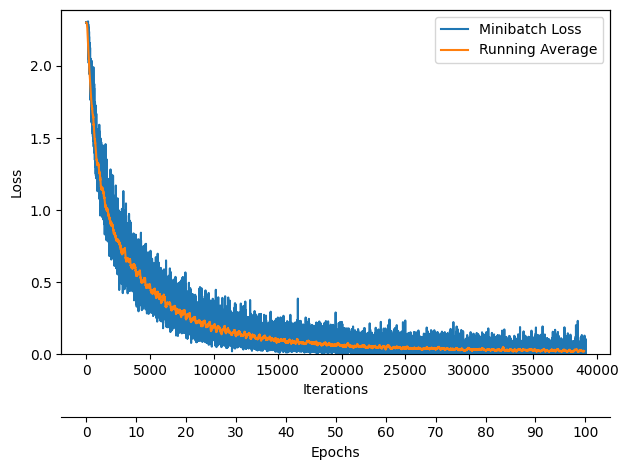

In [15]:
plot_training_loss(minibatch_loss_list=minibatch_loss_list,
                   num_epochs=NUM_EPOCHS,
                   iter_per_epoch=len(train_loader),
                   results_dir=None,
                   averaging_iterations=100)
plt.show()

**Plotting accuracies**

In [16]:
def plot_accuracy(train_acc_list, test_acc_list, results_dir):

    num_epochs = len(train_acc_list)

    plt.plot(np.arange(1, num_epochs+1),
             train_acc_list, label='Training')
    plt.plot(np.arange(1, num_epochs+1),
             test_acc_list, label='Validation')

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    if results_dir is not None:
        image_path = os.path.join(
            results_dir, 'plot_acc_training_validation.pdf')
        plt.savefig(image_path)

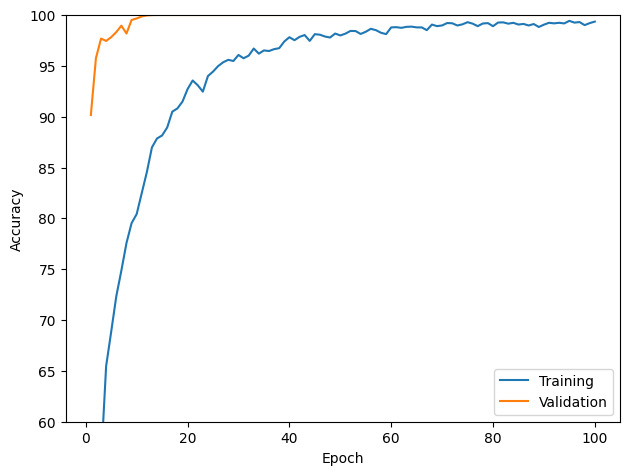

In [17]:
plot_accuracy(train_acc_list=train_acc_list,
              test_acc_list=test_acc_list,
              results_dir=None)
plt.ylim([60, 100])
plt.show()

**Confusion matrix**

In [18]:
def compute_confusion_matrix(model, data_loader, device):

    all_targets, all_predictions = [], []
    with torch.no_grad():

        for i, (features, targets) in enumerate(data_loader):

            features = features.to(device)
            targets = targets
            logits = model(features)
            _, predicted_labels = torch.max(logits, 1)
            all_targets.extend(targets.to('cpu'))
            all_predictions.extend(predicted_labels.to('cpu'))

    all_predictions = all_predictions
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    class_labels = np.unique(np.concatenate((all_targets, all_predictions)))
    if class_labels.shape[0] == 1:
        if class_labels[0] != 0:
            class_labels = np.array([0, class_labels[0]])
        else:
            class_labels = np.array([class_labels[0], 1])
    n_labels = class_labels.shape[0]
    lst = []
    z = list(zip(all_targets, all_predictions))
    for combi in product(class_labels, repeat=2):
        lst.append(z.count(combi))
    mat = np.asarray(lst)[:, None].reshape(n_labels, n_labels)

    return mat

In [19]:
def plot_confusion_matrix(conf_mat,
                          hide_spines=False,
                          hide_ticks=False,
                          figsize=None,
                          cmap=None,
                          colorbar=False,
                          show_absolute=True,
                          show_normed=False,
                          class_names=None):

    if not (show_absolute or show_normed):
        raise AssertionError('Both show_absolute and show_normed are False')
    if class_names is not None and len(class_names) != len(conf_mat):
        raise AssertionError('len(class_names) should be equal to number of'
                             'classes in the dataset')

    total_samples = conf_mat.sum(axis=1)[:, np.newaxis]
    normed_conf_mat = conf_mat.astype('float') / total_samples

    fig, ax = plt.subplots(figsize=figsize)
    ax.grid(False)
    if cmap is None:
        cmap = plt.cm.Blues

    if figsize is None:
        figsize = (len(conf_mat)*6, len(conf_mat)*6)

    if show_normed:
        matshow = ax.matshow(normed_conf_mat, cmap=cmap)
    else:
        matshow = ax.matshow(conf_mat, cmap=cmap)

    if colorbar:
        fig.colorbar(matshow)

    for i in range(conf_mat.shape[0]):
        for j in range(conf_mat.shape[1]):
            cell_text = ""
            if show_absolute:
                cell_text += format(conf_mat[i, j], 'd')
                if show_normed:
                    cell_text += "\n" + '('
                    cell_text += format(normed_conf_mat[i, j], '.2f') + ')'
            else:
                cell_text += format(normed_conf_mat[i, j], '.2f')
            ax.text(x=j,
                    y=i,
                    s=cell_text,
                    va='center',
                    ha='center',
                    color="white" if normed_conf_mat[i, j] > 0.5 else "black")

    if class_names is not None:
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=90)
        plt.yticks(tick_marks, class_names)

    if hide_spines:
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    if hide_ticks:
        ax.axes.get_yaxis().set_ticks([])
        ax.axes.get_xaxis().set_ticks([])

    plt.xlabel('predicted label')
    plt.ylabel('true label')

    return fig, ax

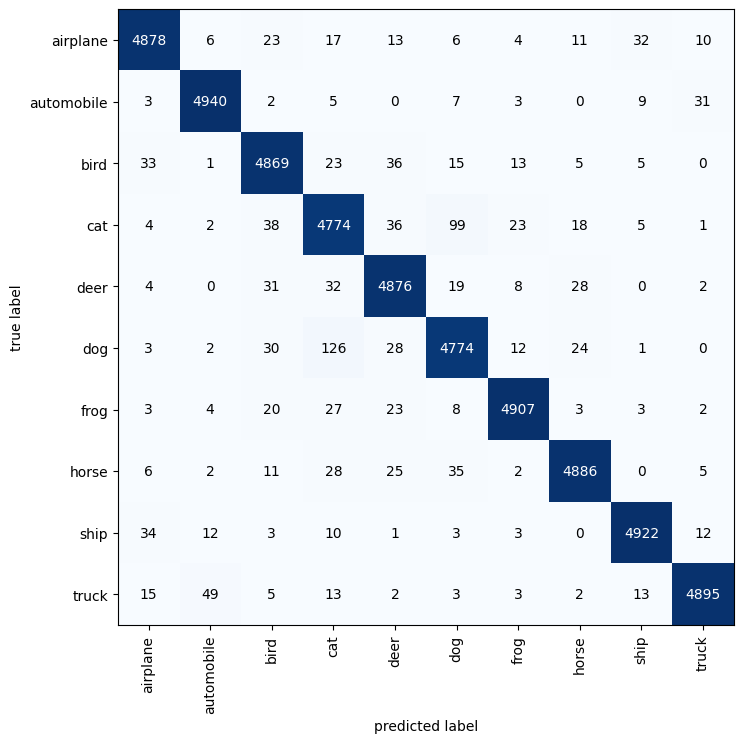

In [21]:
# Unmounting the model to the cpu
model.cpu()

# CIFAR-10 classes
class_dict = {0: 'airplane',
              1: 'automobile',
              2: 'bird',
              3: 'cat',
              4: 'deer',
              5: 'dog',
              6: 'frog',
              7: 'horse',
              8: 'ship',
              9: 'truck'}

mat = compute_confusion_matrix(model=model, data_loader=train_loader, device=torch.device('cpu'))
plot_confusion_matrix(mat, figsize=(8, 8), class_names=class_dict.values())

plt.show()